# Домашнее задание. Классификация изображений.


В данном задании нам требуется классифицировать персонажей из мультсериала "Симпсоны"

In [ ]:
import numpy as np
import pandas as pd
import torch
from torchvision import transforms as tfs
from torchvision import models

import pickle
from skimage import io

from subprocess import call
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

#import gdown
from zipfile import ZipFile

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Training will be done on:', DEVICE.type)

Training will be done on: cuda


## Часть 1. Преобразования исходного датасета

### 1.1 Загрузка датасета

In [ ]:
# Downloading journey-springfield dataset from google drive and unzipping
# url = "https://drive.usercontent.google.com/download?id=1rEuKoR1VUhITyZjVmuCo1DtUNoTOQNCx&export=download&authuser=0&confirm=t&uuid=91a23916-c690-4cf8-a54d-a3e44c5c088b&at=APZUnTUnoLIx8tXF2PDnO-ybioam:1700219641232"
# output = "journey-springfield.zip"
# gdown.download(url, output, quiet=True)

# zf = ZipFile('/content/journey-springfield.zip', 'r')
# zf.extractall('')
# zf.close()

In [ ]:
# Different modes of dataset
DATA_MODES = ['train', 'val', 'test']
# Scaling all images to 224x224 px
RESCALE_SIZE = 224
# Paths to train and test data
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset')

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Dataset with images, which applies parallel loading from folders, scaling
    and transforming to torch.Tensor
    """
    def __init__(self, files, mode):
        super().__init__()

        self.files = sorted(files)
        self.mode = mode    # train / test / val
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            # Writing label_encoder to `label_encoder.pkl`
            with open('label_encoder.pkl', 'wb') as dumped_file:
                  pickle.dump(self.label_encoder, dumped_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):

        transform = tfs.Compose([
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)
train_labels = [path.parent.name for path in train_files]

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

### 1.2 Визуализация датасета и распределений его классов

Вначале посмотрим, как выглядят изображения из нашего датасета

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for torch.Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

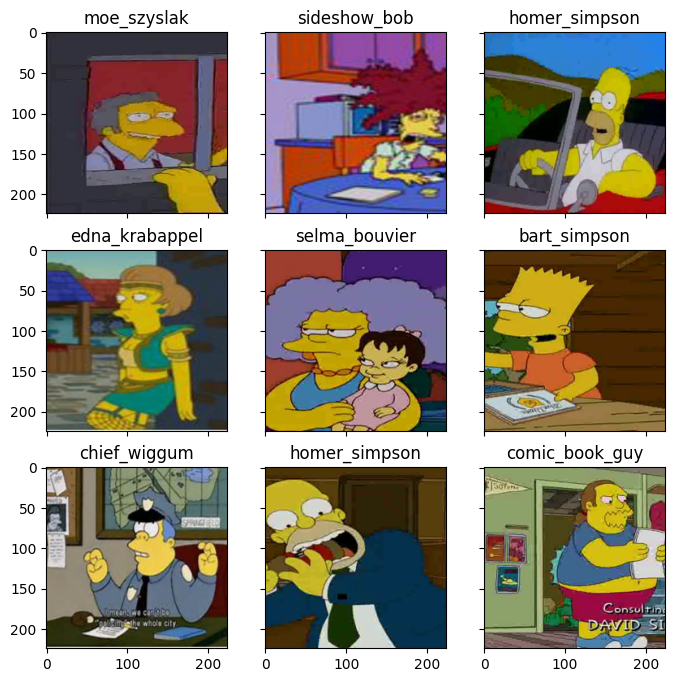

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), \
                        sharey=True, sharex=True)
for ax_c in ax.flatten():
    rand_n = np.random.randint(0, train_dataset.len_ - 1)
    im_train, label = train_dataset[rand_n]
    img_label = train_dataset.label_encoder.inverse_transform([label])[0]
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=ax_c)

Далее посмотрим, как распределены классы (построим гистограмму, на которой будет показано, сколько экземпляров каждого класса есть в датасете)

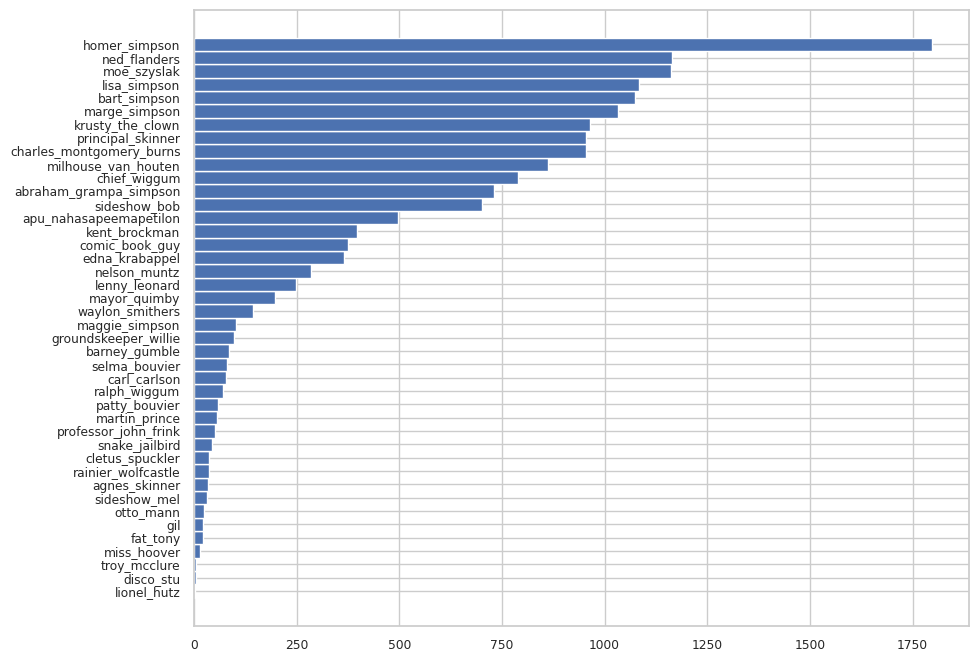

In [ ]:
sns.set(style="whitegrid", font_scale=0.8)

train_labels_counts = pd.Series(train_labels).value_counts()
plt.figure(figsize=(10, 8))
plt.barh(y=train_labels_counts.keys()[::-1],
         width=train_labels_counts.sort_values(ascending=True),
         height=1)
plt.show()

### 1.3 Балансировка классов

Можно заметить, что классы в датасете сильно несбалансированы, для улучшения качества модели нужно их уравновесить

In [ ]:
weights = []
len_train = train_dataset.len_


weights = [1/train_labels_counts.loc[label] for label in train_dataset.labels]

In [ ]:
n_samples = int(train_labels_counts.max()) * len(train_labels_counts)
weighted_sampler = WeightedRandomSampler(weights=weights,
                                         num_samples=n_samples,
                                         replacement=True)

## Часть 2. Подбор модели и обучение

### 2.1 Необходимые функции для обучения

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, opt):
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=weighted_sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=64, num_workers=2)
    metrics = []
    max_acc = 0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            metrics.append((train_loss, train_acc, val_loss, val_acc))
            if val_acc >= max_acc:
                max_acc = val_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    return metrics, max_acc, best_model_wts

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### 2.2 Простейшая CNN из задания

In [ ]:
# Very simple network
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify: {} classes".format(n_classes))
print(simple_cnn)

we will classify: 42 classes
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400,

In [ ]:
optim = torch.optim.Adam(simple_cnn.parameters())
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, opt=optim)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.022855546535614


epoch:  10%|█         | 1/10 [05:03<45:34, 303.82s/it]


Epoch 001 train_loss: 1.0229     val_loss 1.4072 train_acc 0.7357 val_acc 0.6580
loss 0.2782936021734959


epoch:  20%|██        | 2/10 [09:29<37:31, 281.48s/it]


Epoch 002 train_loss: 0.2783     val_loss 1.3014 train_acc 0.9255 val_acc 0.7163
loss 0.16376979651041268


epoch:  30%|███       | 3/10 [13:54<31:57, 273.90s/it]


Epoch 003 train_loss: 0.1638     val_loss 1.3189 train_acc 0.9547 val_acc 0.7442
loss 0.11966201736747903


epoch:  40%|████      | 4/10 [18:19<27:01, 270.21s/it]


Epoch 004 train_loss: 0.1197     val_loss 1.4734 train_acc 0.9650 val_acc 0.7356
loss 0.08912164723820898


epoch:  50%|█████     | 5/10 [22:39<22:13, 266.74s/it]


Epoch 005 train_loss: 0.0891     val_loss 1.3544 train_acc 0.9737 val_acc 0.7514
loss 0.07295304000933235


epoch:  60%|██████    | 6/10 [27:04<17:44, 266.12s/it]


Epoch 006 train_loss: 0.0730     val_loss 1.6820 train_acc 0.9782 val_acc 0.7564
loss 0.06304440455239049


epoch:  70%|███████   | 7/10 [31:28<13:16, 265.47s/it]


Epoch 007 train_loss: 0.0630     val_loss 1.5253 train_acc 0.9807 val_acc 0.7614
loss 0.05174709745475852


epoch:  80%|████████  | 8/10 [35:53<08:50, 265.23s/it]


Epoch 008 train_loss: 0.0517     val_loss 1.5446 train_acc 0.9842 val_acc 0.7769
loss 0.0434779486331595


epoch:  90%|█████████ | 9/10 [40:17<04:24, 264.98s/it]


Epoch 009 train_loss: 0.0435     val_loss 1.7035 train_acc 0.9869 val_acc 0.7650
loss 0.042223056796848964


epoch: 100%|██████████| 10/10 [44:38<00:00, 267.81s/it]


Epoch 010 train_loss: 0.0422     val_loss 1.6474 train_acc 0.9875 val_acc 0.7700


In [ ]:
metrics_simplecnn = history[0]
max_acc = history[1]

print('maximum accuracy for SimpleCNN is:', max_acc.item())

maximum accuracy for SimpleCNN is: 0.7769285884881777


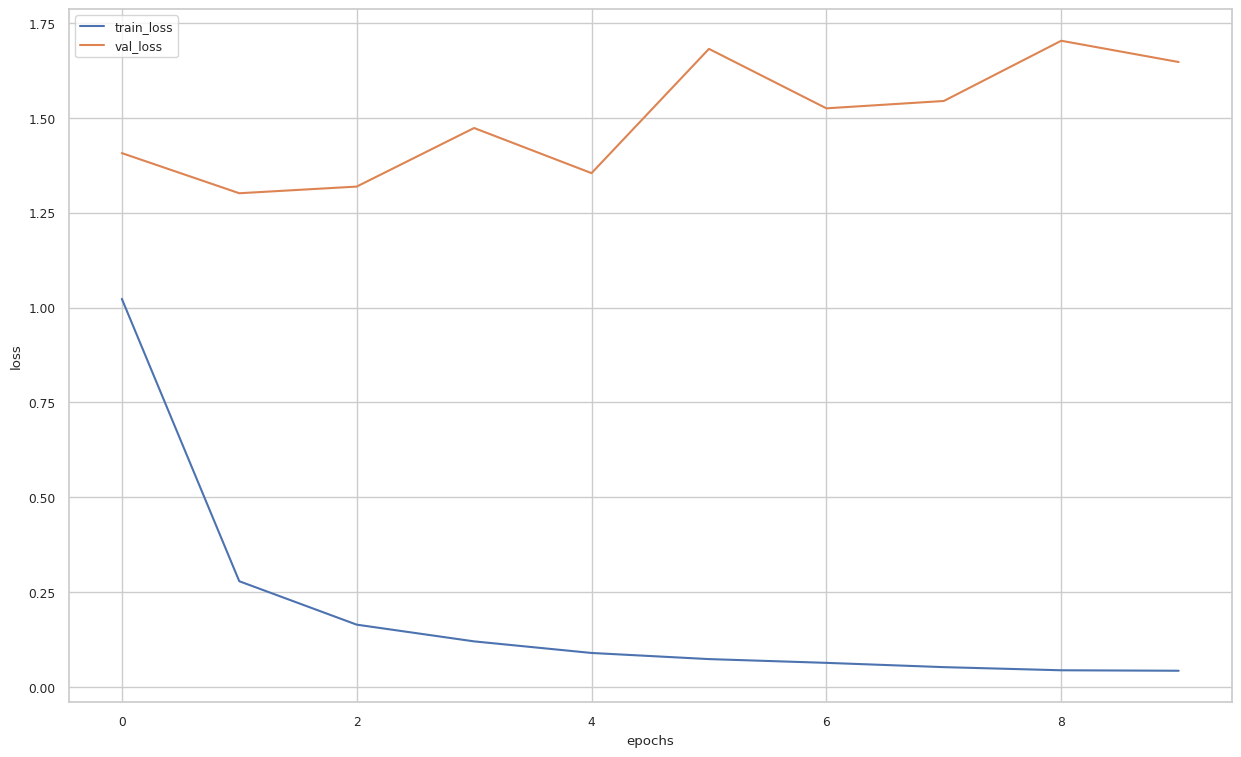

In [ ]:
loss, acc, val_loss, val_acc = zip(*metrics_simplecnn)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Вывод: долгое обучение и низкое accuracy, которое нас не устраивает. Попробуем выбрать другую более сложную архитектуру и добавить в датасет аугментации.

### 2.3 Pretrained ResNet50 + augmentations

In [ ]:
# Adding augmentations
class SimpsonsAugmented(SimpsonsDataset):
    def __getitem__(self, index):
        augm = tfs.RandomChoice([
            tfs.Compose([
                tfs.CenterCrop(270),
                tfs.RandomCrop(224)
            ]),
            tfs.RandomRotation(degrees=(-25,25)),
            tfs.RandomHorizontalFlip(p=1)
        ])
        transform = tfs.Compose([
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            x = augm(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
train_dataset = SimpsonsAugmented(train_files, mode='train')
val_dataset = SimpsonsAugmented(val_files, mode='val')
test_dataset = SimpsonsAugmented(test_files, mode='test')

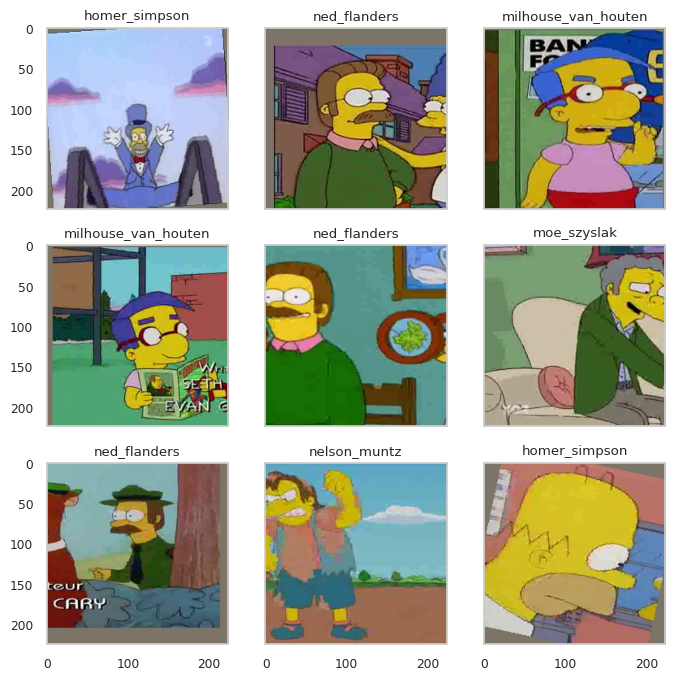

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), \
                        sharey=True, sharex=True)
for ax_c in ax.flatten():
    rand_n = np.random.randint(0, train_dataset.len_ - 1)
    im_train, label = train_dataset[rand_n]
    img_label = train_dataset.label_encoder.inverse_transform([label])[0]
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=ax_c)

In [ ]:
model_extractor = models.resnet50(pretrained=True)
param_to_optimize = []

for i, block in enumerate(model_extractor.children()):
    for param in block.parameters():
        if i < 6:
            param.requires_grad=False
        else:
            param_to_optimize.append(param)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s] 


In [ ]:
in_features_fc = model_extractor.fc.in_features
model_extractor.fc = nn.Linear(in_features_fc, n_classes)

In [ ]:
optim = torch.optim.Adam(param_to_optimize, lr=1e-4)
model_extractor.to(DEVICE)
history = train(train_dataset, val_dataset, model=model_extractor, epochs=10, opt=optim)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.24058828528066328


epoch:  10%|█         | 1/10 [05:42<51:26, 342.93s/it]


Epoch 001 train_loss: 0.2406     val_loss 0.1541 train_acc 0.9570 val_acc 0.9658
loss 0.11105434904817496


epoch:  20%|██        | 2/10 [11:27<45:49, 343.66s/it]


Epoch 002 train_loss: 0.1111     val_loss 0.2086 train_acc 0.9724 val_acc 0.9549
loss 0.04220558004981298


epoch:  30%|███       | 3/10 [17:16<40:22, 346.08s/it]


Epoch 003 train_loss: 0.0422     val_loss 0.2774 train_acc 0.9895 val_acc 0.9403
loss 0.04061585313173763


epoch:  40%|████      | 4/10 [23:00<34:31, 345.33s/it]


Epoch 004 train_loss: 0.0406     val_loss 0.2845 train_acc 0.9896 val_acc 0.9458
loss 0.03550889658590048


epoch:  50%|█████     | 5/10 [28:46<28:47, 345.57s/it]


Epoch 005 train_loss: 0.0355     val_loss 0.2969 train_acc 0.9911 val_acc 0.9396
loss 0.02906663451038778


epoch:  60%|██████    | 6/10 [34:34<23:06, 346.60s/it]


Epoch 006 train_loss: 0.0291     val_loss 0.1828 train_acc 0.9927 val_acc 0.9658
loss 0.02978322364757817


epoch:  70%|███████   | 7/10 [40:26<17:25, 348.34s/it]


Epoch 007 train_loss: 0.0298     val_loss 0.1650 train_acc 0.9928 val_acc 0.9670
loss 0.020227792331546868


epoch:  80%|████████  | 8/10 [46:19<11:39, 349.59s/it]


Epoch 008 train_loss: 0.0202     val_loss 0.1515 train_acc 0.9948 val_acc 0.9685
loss 0.023041668271786806


epoch:  90%|█████████ | 9/10 [52:04<05:48, 348.31s/it]


Epoch 009 train_loss: 0.0230     val_loss 0.1531 train_acc 0.9942 val_acc 0.9718
loss 0.020292408077163496


epoch: 100%|██████████| 10/10 [57:52<00:00, 347.27s/it]


Epoch 010 train_loss: 0.0203     val_loss 0.1749 train_acc 0.9949 val_acc 0.9678


In [ ]:
metrics_resnet50 = history[0]
max_acc = history[1]
model_extractor.load_state_dict(history[2])
print('maximum accuracy for ResNet50 is:', max_acc.item())

maximum accuracy for ResNet50 is: 0.9718175304513972


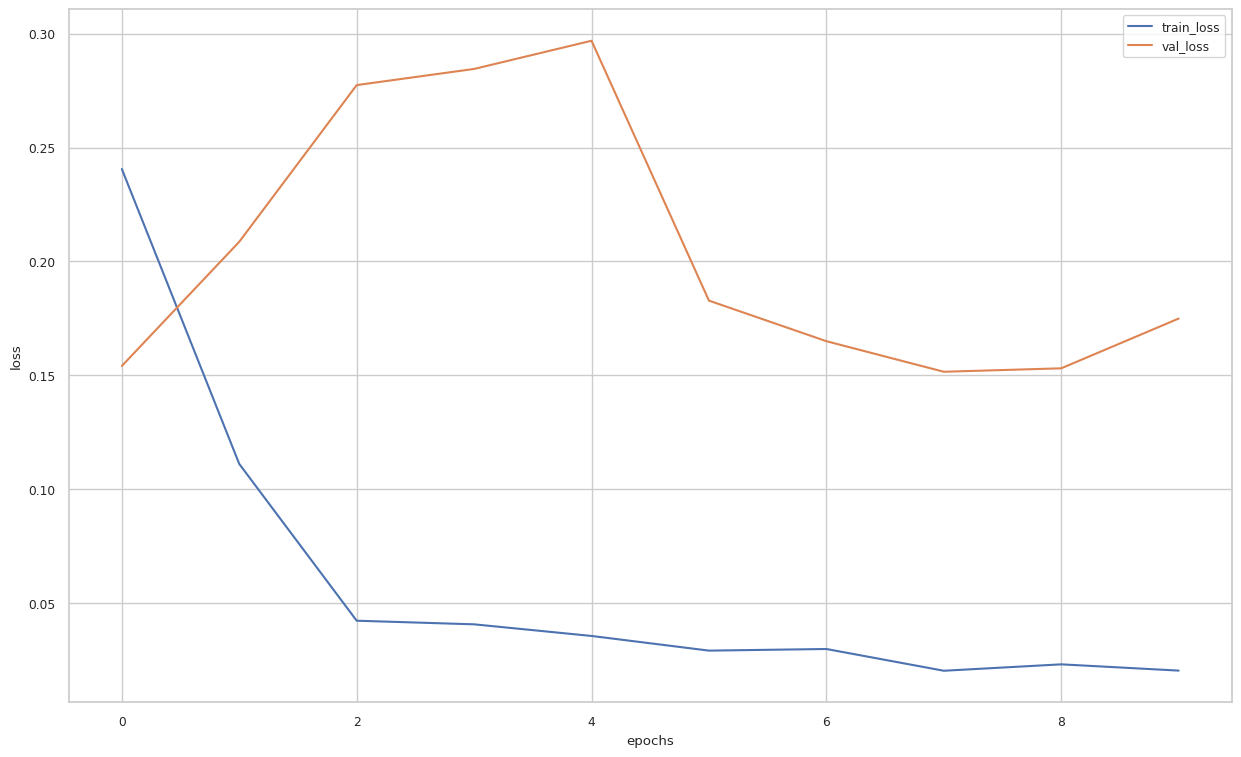

In [ ]:
loss, acc, val_loss, val_acc = zip(*metrics_resnet50)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

##  Часть 3. Предсказания и сабмит на kaggle

In [ ]:
idxs = list(range(0, val_dataset.len_))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

y_pred = np.argmax(predict(model_extractor, imgs), -1)
actual_labels = [val_dataset[id][1] for id in idxs]

Вычислим целевую метрику на валидационной выборке

In [ ]:
from sklearn.metrics import f1_score
#actual_labels = predict(model_extractor, imgs)
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.9658466682588965


In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)


preds = train_dataset.label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('my_submission.csv', index=False)

Итоговый score на kaggle получился выше, чем на валидации:

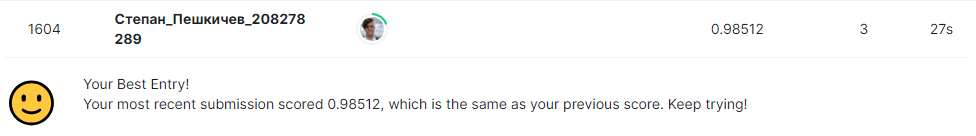